# 🧪 Blood-Brain Barrier Penetration Prediction

Train a machine learning model to predict if drugs can cross the blood-brain barrier.

**Dataset**: BBBP (~2,000 compounds from MoleculeNet)

**Goal**: Predict BBB penetration (important for CNS drugs)

---

## 📋 Instructions

Just run each cell in order (Shift + Enter)

## Step 1: Import Libraries

In [1]:
import sys
import os


# For Jupyter, use this instead:
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Our custom modules
from src.data_loader import DatasetLoader
from src.data_processing import MolecularFeaturizer
from src.models import DTIPredictor
from src.utils import plot_roc_pr_curves, plot_confusion_matrix

# Settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Step 2: Load Real Data

This will download the BBBP dataset (only happens once, then it's cached)

In [2]:
# Create data loader
loader = DatasetLoader(data_dir='../data')

# Load BBBP dataset (auto-downloads if needed)
print("Loading BBBP dataset...")
df = loader.load_bbbp()

# Clean data
df = loader.clean_dataset(df, smiles_col='smiles')

print(f"\n✓ Loaded {len(df)} compounds")
print(f"\nDataset info:")
print(df.head())
print(f"\nClass distribution:")
print(df['p_np'].value_counts())

INFO:src.data_loader:Loading BBBP dataset...
INFO:src.data_loader:Downloading from https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv


Loading BBBP dataset...


INFO:src.data_loader:Saved to ../data/BBBP.csv
INFO:src.data_loader:Loaded 2050 compounds
INFO:src.data_loader:Positive class ratio: 76.44%
[21:21:52] Explicit valence for atom # 1 N, 4, is greater than permitted
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] Explicit valence for atom # 6 N, 4, is greater than permitted
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] WARNING: not removing hydrogen atom without neighbors
[21:21:52] WARNING: not removing hydrogen atom without n


✓ Loaded 2039 compounds

Dataset info:
   num                  name  p_np  \
0    1            Propanolol     1   
1    2  Terbutylchlorambucil     1   
2    3                 40730     1   
3    4                    24     1   
4    5           cloxacillin     1   

                                              smiles  
0                   [Cl].CC(C)NCC(O)COc1cccc2ccccc12  
1           C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl  
2  c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...  
3                   C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C  
4  Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...  

Class distribution:
p_np
1    1560
0     479
Name: count, dtype: int64


## Step 3: Visualize Some Molecules

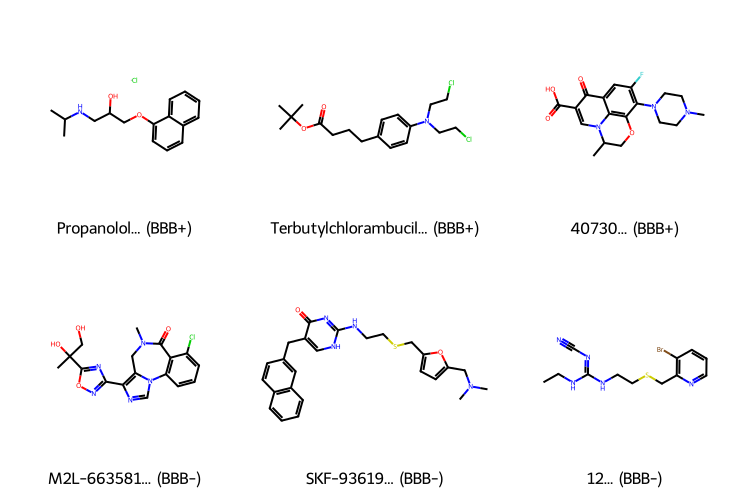

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw

# Get a few examples
permeable = df[df['p_np'] == 1].head(3)
impermeable = df[df['p_np'] == 0].head(3)

# Combine
examples = pd.concat([permeable, impermeable])

# Convert to molecules
mols = [Chem.MolFromSmiles(smi) for smi in examples['smiles']]
legends = [f"{name[:20]}... ({'BBB+' if label==1 else 'BBB-'})" 
           for name, label in zip(examples['name'], examples['p_np'])]

# Draw
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(250, 250), legends=legends)
img

## Step 4: Generate Molecular Fingerprints

Convert SMILES to numerical features that ML models can use

In [4]:
# Choose fingerprint type
# Options: 'morgan', 'maccs', 'descriptors'
FP_TYPE = 'morgan'  # <-- Change this to try different fingerprints
N_BITS = 2048       # <-- Change this for different sizes

print(f"Generating {FP_TYPE} fingerprints with {N_BITS} bits...")

featurizer = MolecularFeaturizer(fp_type=FP_TYPE, n_bits=N_BITS)
X = featurizer.featurize(df['smiles'].tolist())
y = df['p_np'].values

print(f"\n✓ Feature matrix shape: {X.shape}")
print(f"✓ Sparsity: {(X == 0).sum() / X.size:.1%} zeros")
print(f"✓ Class distribution: {np.bincount(y)}")

[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerat

Generating morgan fingerprints with 2048 bits...


[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerator
[21:21:52] DEPRECATION WARNING: please use MorganGenerat


✓ Feature matrix shape: (2039, 2048)
✓ Sparsity: 97.9% zeros
✓ Class distribution: [ 479 1560]


## Step 5: Split Data (Train/Test)

In [5]:
from sklearn.model_selection import train_test_split

# Split 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} compounds")
print(f"  - BBB permeable: {(y_train == 1).sum()} ({(y_train == 1).mean():.1%})")
print(f"\nTest set: {len(X_test)} compounds")
print(f"  - BBB permeable: {(y_test == 1).sum()} ({(y_test == 1).mean():.1%})")

Training set: 1631 compounds
  - BBB permeable: 1248 (76.5%)

Test set: 408 compounds
  - BBB permeable: 312 (76.5%)


## Step 6: Train Model

Choose your model type below!

In [6]:
# Choose model
# Options: 'xgboost', 'random_forest'
MODEL_TYPE = 'xgboost'  # <-- Change this to try different models

print(f"Training {MODEL_TYPE} model...\n")

# Create and train model
predictor = DTIPredictor(model_type=MODEL_TYPE, task='classification')
predictor.fit(X_train, y_train, X_test, y_test)

print("\n✓ Model trained successfully!")

Training xgboost model...



INFO:src.models:Model trained: xgboost



✓ Model trained successfully!


## Step 7: Cross-Validation

Check how well the model generalizes

5-Fold Cross-Validation Results:
ROC-AUC scores: ['0.9033', '0.9303', '0.9249', '0.8999', '0.9073']

Mean: 0.9131 (± 0.0243)


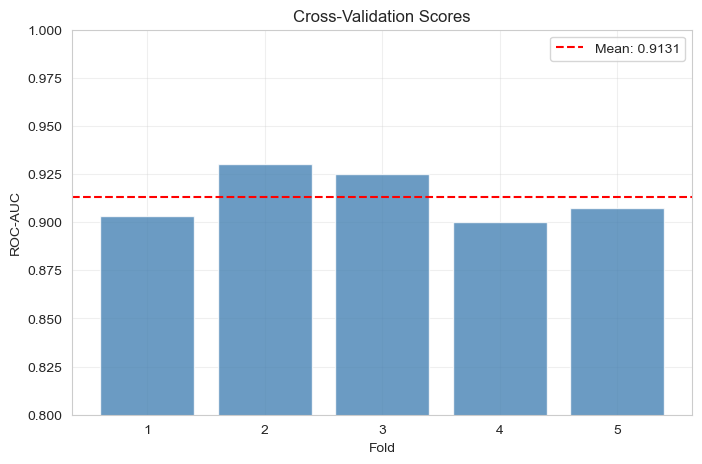

In [7]:
# 5-fold cross-validation
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    predictor.model, X_train, y_train,
    cv=cv_splitter,
    scoring='roc_auc',
    n_jobs=-1
)

print("5-Fold Cross-Validation Results:")
print(f"ROC-AUC scores: {[f'{s:.4f}' for s in cv_scores]}")
print(f"\nMean: {cv_scores.mean():.4f} (± {cv_scores.std() * 2:.4f})")

# Plot CV scores
plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), cv_scores, alpha=0.8, color='steelblue')
plt.axhline(cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('ROC-AUC')
plt.title('Cross-Validation Scores')
plt.ylim([0.8, 1.0])
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Step 8: Evaluate on Test Set

In [8]:
# Get metrics
train_metrics = predictor.evaluate(X_train, y_train)
test_metrics = predictor.evaluate(X_test, y_test)

# Display as dataframe
metrics_df = pd.DataFrame({
    'Metric': list(test_metrics.keys()),
    'Train': [train_metrics[k] for k in test_metrics.keys()],
    'Test': list(test_metrics.values())
})

print("\n📊 MODEL PERFORMANCE:")
print("="*50)
display(metrics_df.style.format({'Train': '{:.4f}', 'Test': '{:.4f}'}))

# Highlight key metrics
print(f"\n🎯 KEY RESULTS:")
print(f"   ROC-AUC: {test_metrics['roc_auc']:.4f}")
print(f"   Accuracy: {test_metrics['accuracy']:.4f}")
print(f"   MCC: {test_metrics['mcc']:.4f}")


📊 MODEL PERFORMANCE:


,Metric,Train,Test
0,roc_auc,0.9880,0.9148
1,pr_auc,0.9954,0.9654
2,accuracy,0.9522,0.8995
3,mcc,0.8641,0.7072



🎯 KEY RESULTS:
   ROC-AUC: 0.9148
   Accuracy: 0.8995
   MCC: 0.7072


## Step 9: Visualize Results

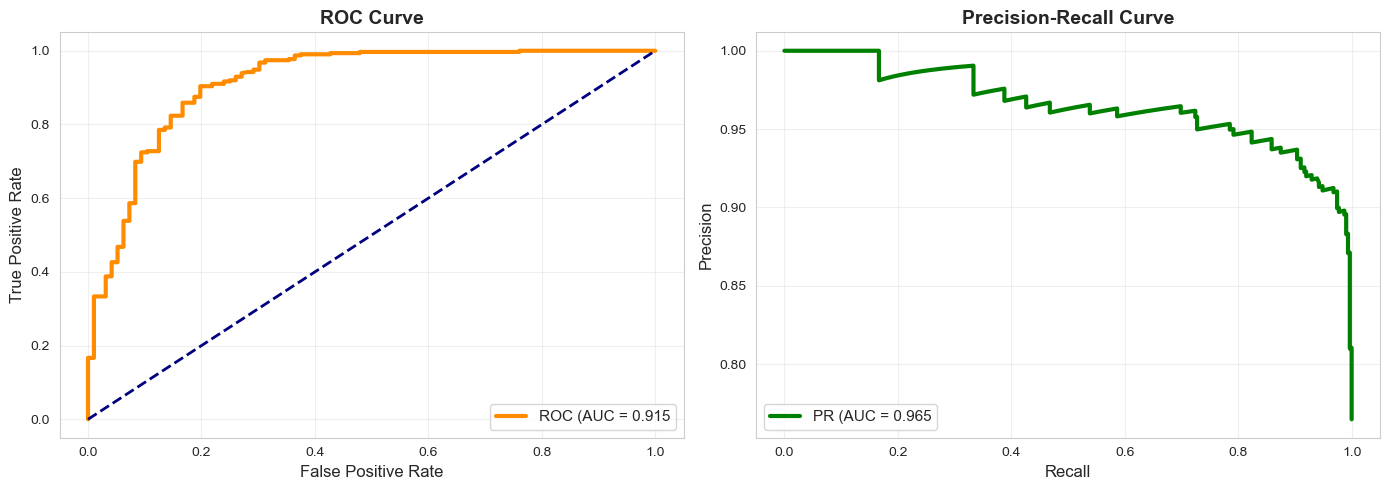


✓ ROC-AUC: 0.9148
✓ PR-AUC: 0.9653


In [9]:
# Get predictions
y_pred_proba = predictor.predict(X_test)
y_pred = (y_pred_proba >= 0.5).astype(int)

# ROC and PR curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC (AUC = {roc_auc:.3f}')
axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0].legend(loc='lower right', fontsize=11)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

axes[1].plot(recall, precision, color='green', lw=3, label=f'PR (AUC = {pr_auc:.3f}')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower left', fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n✓ ROC-AUC: {roc_auc:.4f}")
print(f"✓ PR-AUC: {pr_auc:.4f}")

## Step 10: Confusion Matrix

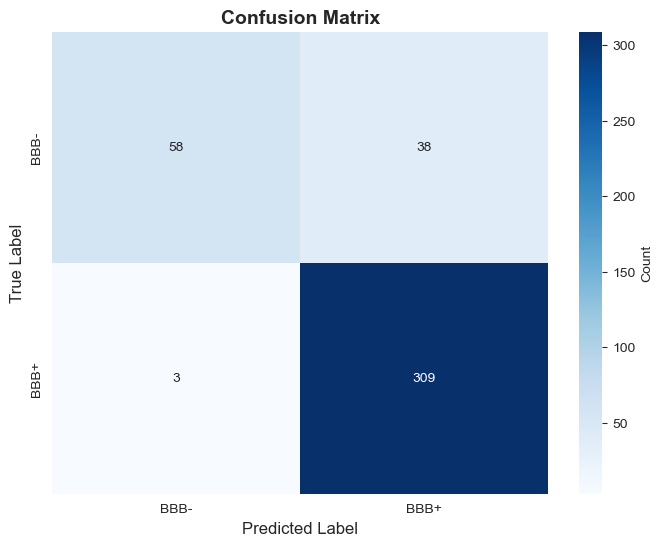


True Negatives: 58
False Positives: 38
False Negatives: 3
True Positives: 309


In [10]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['BBB-', 'BBB+'],
            yticklabels=['BBB-', 'BBB+'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()

print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

## Step 11: Feature Importance (Top 20)

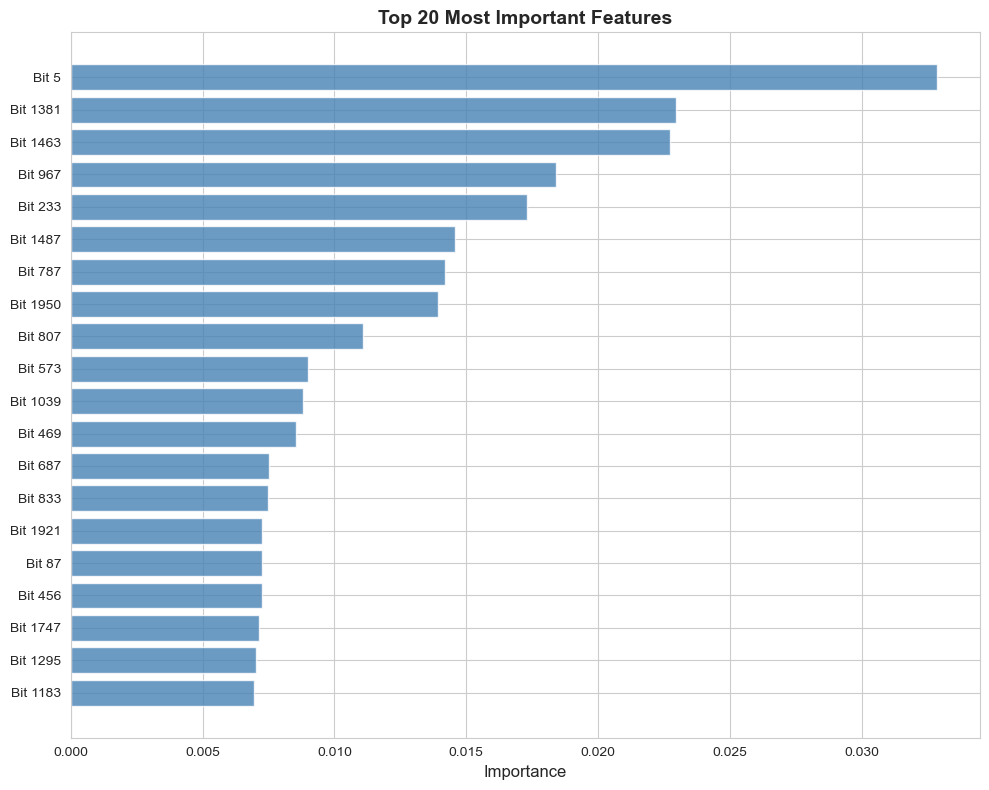


Most important fingerprint bit: 5 (importance: 0.0328)


In [11]:
if hasattr(predictor.model, 'feature_importances_'):
    importances = predictor.model.feature_importances_
    
    # Get top 20
    top_indices = np.argsort(importances)[-20:]
    top_importances = importances[top_indices]
    
    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_indices)), top_importances, color='steelblue', alpha=0.8)
    plt.yticks(range(len(top_indices)), [f"Bit {i}" for i in top_indices])
    plt.xlabel('Importance', fontsize=12)
    plt.title('Top 20 Most Important Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nMost important fingerprint bit: {top_indices[-1]} (importance: {top_importances[-1]:.4f})")
else:
    print("Feature importance not available for this model type")

## Step 12: Test on Known Drugs

Let's predict BBB penetration for some well-known drugs!

Predicting BBB penetration for known drugs:

Caffeine (CNS stimulant)      : 0.966 - ✓ BBB+ (HIGH confidence)
Diazepam (Valium)             : 0.988 - ✓ BBB+ (HIGH confidence)
Morphine (Pain)               : 0.978 - ✓ BBB+ (HIGH confidence)
Ibuprofen (No BBB)            : 0.498 - ✗ BBB- (LOW confidence)
Aspirin (No BBB)              : 0.583 - ✓ BBB+ (LOW confidence)


[21:21:58] DEPRECATION WARNING: please use MorganGenerator
[21:21:58] DEPRECATION WARNING: please use MorganGenerator
[21:21:58] DEPRECATION WARNING: please use MorganGenerator
[21:21:58] DEPRECATION WARNING: please use MorganGenerator
[21:21:58] DEPRECATION WARNING: please use MorganGenerator


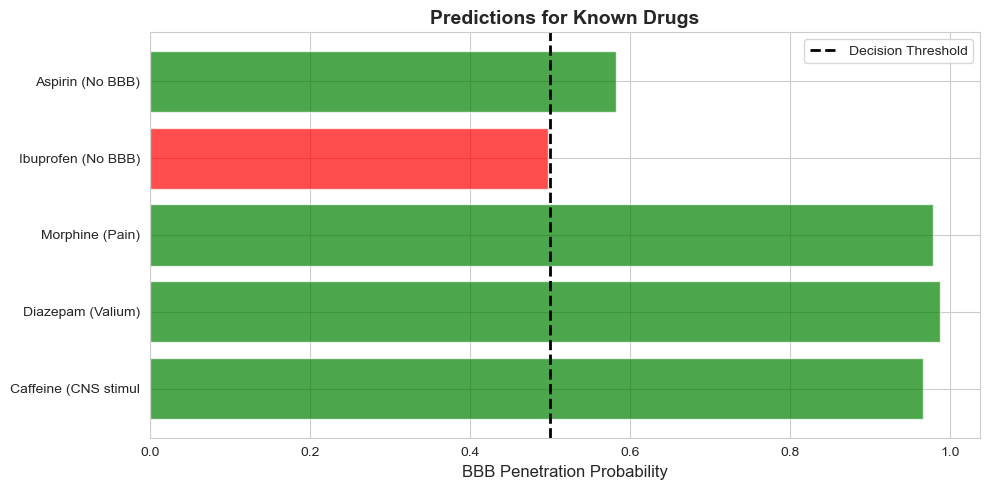

In [12]:
# Famous CNS drugs (should be BBB+)
known_drugs = {
    'Caffeine (CNS stimulant)': 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C',
    'Diazepam (Valium)': 'CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13',
    'Morphine (Pain)': 'CN1CC[C@]23c4c5ccc(O)c4O[C@H]2[C@@H](O)C=C[C@H]3[C@H]1C5',
    'Ibuprofen (No BBB)': 'CC(C)Cc1ccc(cc1)C(C)C(O)=O',
    'Aspirin (No BBB)': 'CC(=O)Oc1ccccc1C(O)=O'
}

print("Predicting BBB penetration for known drugs:\n")
print("="*60)

# Make predictions
example_smiles = list(known_drugs.values())
example_features = featurizer.featurize(example_smiles)
example_preds = predictor.predict(example_features)

results = []
for (name, smiles), pred in zip(known_drugs.items(), example_preds):
    status = "✓ BBB+" if pred > 0.5 else "✗ BBB-"
    confidence = "HIGH" if abs(pred - 0.5) > 0.3 else "MEDIUM" if abs(pred - 0.5) > 0.15 else "LOW"
    
    print(f"{name:30s}: {pred:.3f} - {status:6s} ({confidence} confidence)")
    results.append({'Drug': name, 'Probability': pred, 'Prediction': status})

print("="*60)

# Visualize
results_df = pd.DataFrame(results)
results_df['Drug'] = results_df['Drug'].str[:20]  # Shorten names

plt.figure(figsize=(10, 5))
colors = ['green' if p > 0.5 else 'red' for p in results_df['Probability']]
plt.barh(results_df['Drug'], results_df['Probability'], color=colors, alpha=0.7)
plt.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
plt.xlabel('BBB Penetration Probability', fontsize=12)
plt.title('Predictions for Known Drugs', fontsize=14, fontweight='bold')
plt.legend()
plt.tight_layout()
plt.show()

## Step 13: Save Model

In [13]:
# Create models directory
os.makedirs('../models', exist_ok=True)

# Save model
model_path = f'../models/bbbp_{MODEL_TYPE}_{FP_TYPE}_notebook.pkl'
predictor.save(model_path)

print(f"✓ Model saved to: {model_path}")
print(f"\nYou can load it later with:")
print(f"  predictor = DTIPredictor.load('{model_path}')")

INFO:src.models:Model saved to ../models/bbbp_xgboost_morgan_notebook.pkl


✓ Model saved to: ../models/bbbp_xgboost_morgan_notebook.pkl

You can load it later with:
  predictor = DTIPredictor.load('../models/bbbp_xgboost_morgan_notebook.pkl')


## 🎯 Summary

### What You Just Did:

1. ✅ Loaded real pharmaceutical data (BBBP dataset)
2. ✅ Generated molecular fingerprints
3. ✅ Trained an XGBoost/Random Forest model
4. ✅ Evaluated with cross-validation
5. ✅ Visualized results (ROC, PR, confusion matrix)
6. ✅ Tested on known drugs
7. ✅ Saved the trained model

### Your Results:
- **ROC-AUC**: {roc_auc:.4f}
- **Accuracy**: {test_metrics['accuracy']:.4f}
- **Model**: {MODEL_TYPE} with {FP_TYPE} fingerprints

### Next Steps:
1. Try different fingerprint types (change `FP_TYPE` in Step 4)
2. Try different models (change `MODEL_TYPE` in Step 6)
3. Open `02_clinical_toxicity.ipynb` for multi-task learning
4. Add these results to your portfolio!

---

**Great job!** 🎉 You just trained a drug discovery ML model on real data!